In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [209]:
# Import grade data
df_grade = pd.read_csv("Data/2020-12-23T0914_Grades-ECO202Y5_Y_All_Sections.csv")
df_grade = df_grade.set_index('ID')

# Import data to match grade and zoom
df_match = pd.read_excel("Data/ID_match.xlsx", sheet_name = "ID and Email")
df_match = df_match.set_index('Email')

In [210]:
# Calculate Term Test 1 and 2 raw score
df_grade['Test 1 - v1'] = df_grade['1357 - Term Test 1 - Part 1 (406688)'] + df_grade['1357 - Term Test 1 - Part 2 (457963)']
df_grade['Test 1 - v2'] = df_grade['2468 - Term Test 1 - Part 1 (457964)'] + df_grade['2468 - Term Test 1 - Part 2 (457965)']

df_grade['Test 1'] = df_grade[['Test 1 - v1', 'Test 1 - v2']].max(axis =1)

df_grade['Test 2 - 12'] = df_grade['12 - Term Test 2 - Part 1 (475535)'] + df_grade['12 - Term Test 2 - Part 2 (475539)']
df_grade['Test 2 - 34'] = df_grade['34 - Term Test 2 - Part 1 (475536)'] + df_grade['34 - Term Test 2 - Part 2 (475540)']
df_grade['Test 2 - v1'] = df_grade[['Test 2 - 12', 'Test 2 - 34']].max(axis =1)

df_grade['Test 2 - 56'] = df_grade['56 - Term Test 2 - Part 1 (475537)'] + df_grade['56 - Term Test 2 - Part 2 (475541)']
df_grade['Test 2 - 78'] = df_grade['78 - Term Test 2 - Part 1 (475538)'] + df_grade['78 - Term Test 2 - Part 2 (475542)']
df_grade['Test 2 - v2'] = df_grade[['Test 2 - 56', 'Test 2 - 78']].max(axis =1)

df_grade['Test 2'] = df_grade[['Test 2 - v1', 'Test 2 - v2']].max(axis =1)

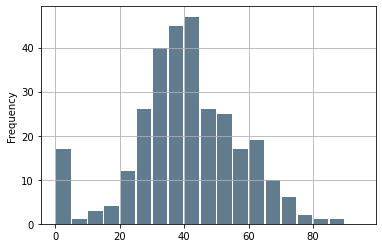

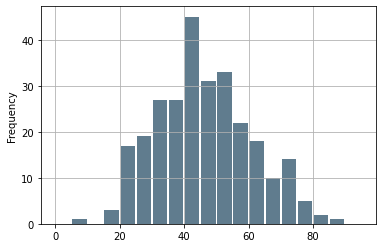

In [249]:
# Histogram of grade
plt.figure()
df_grade['Test 1'].plot.hist(grid=True, bins=np.arange(0,100,5), rwidth=0.9, color='#607c8e')

plt.figure()
df_grade['Test 2'].plot.hist(grid=True, bins=np.arange(0,100,5), rwidth=0.9, color='#607c8e')

In [223]:
# Merge all Zoom lectures
zoom_files = ['Sept16.csv', 'Sept23.csv', 'Sept30.csv', 'Oct7.csv', 'Oct28.csv', 'Nov4.csv', 'Nov11.csv', 'Nov18.csv', 'Nov25.csv']
df_zoom = pd.read_csv('Data/' + zoom_files[0])
df_zoom['Lecture'] = 1

for i in range(1, len(zoom_files)):
    data = pd.read_csv('Data/' + zoom_files[i])
    data['Lecture'] = i + 1
    df_zoom = df_zoom.append(data)

# Match Email with ID in Grade File
df_zoom = df_zoom.dropna(subset =['Email'])
df_zoom.index = np.arange(0, len(df_zoom))

df_zoom['ID'] = df_zoom['Email']

for i in range(0, len(df_zoom)):
    if df_zoom['Email'][i] in list(df_match.index):
        df_zoom['ID'][i] = df_match['ID'][df_zoom['Email'][i]]
    else:
        df_zoom['ID'][i] = float('nan')

# Drop unidentified people
df_zoom = df_zoom.dropna(subset =['ID'])


<BarContainer object of 9 artists>

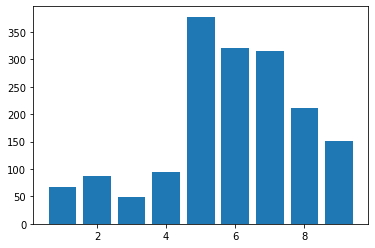

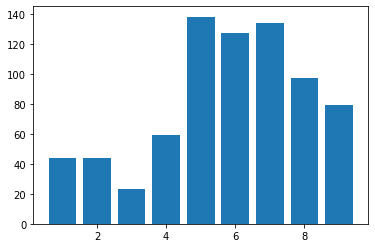

In [224]:
# Plot number of views and viewers by lecture
# Note: Lecture 4 is the last lecture before Term Test 1
views = [0] * 9
viewers = [0] * 9
lecture = [0] * 9

for i in range(0,9):
    lecture[i] = i + 1
    views[i] = len(df_zoom[df_zoom['Lecture'] == i + 1])
    viewers[i] = len(df_zoom['Email'][df_zoom['Lecture'] == i + 1].unique())

plt.bar(lecture, views)
plt.figure()
plt.bar(lecture, viewers)


In [242]:
# Identify students who view videos
df_grade['Test 1 - Watch'] = 0
df_grade['Test 2 - Watch'] = 0

for i in df_zoom['ID'][df_zoom['Lecture'] < 5]:
    df_grade['Test 1 - Watch'][i] = 1

for i in df_zoom['ID'][df_zoom['Lecture'] >= 5]:
    df_grade['Test 2 - Watch'][i] = 1


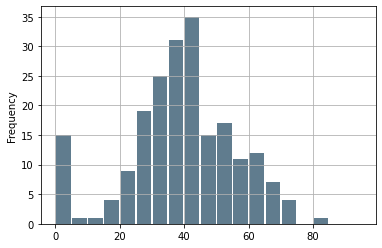

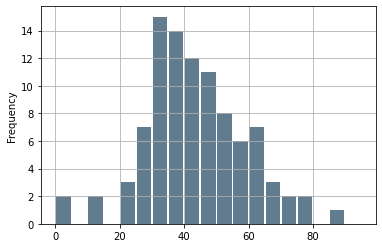

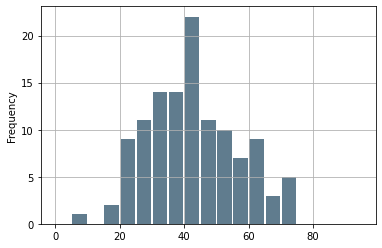

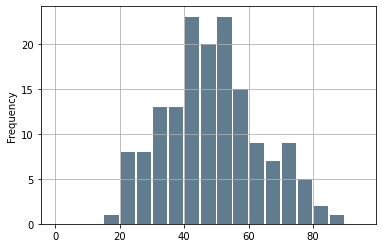

In [248]:
# Historgram of Grade

# Test 1
# Not watch group
plt.figure()
df_grade['Test 1'][df_grade['Test 1 - Watch'] == 0].plot.hist(grid=True, bins=np.arange(0,100,5), rwidth=0.9, color='#607c8e')

# Watch group
plt.figure()
df_grade['Test 1'][df_grade['Test 1 - Watch'] == 1].plot.hist(grid=True, bins=np.arange(0,100,5), rwidth=0.9, color='#607c8e')

#####################################################################################################################
# Test 2
# Not watch group
plt.figure()
df_grade['Test 2'][df_grade['Test 2 - Watch'] == 0].plot.hist(grid=True, bins=np.arange(0,100,5), rwidth=0.9, color='#607c8e')

# Watch group
plt.figure()
df_grade['Test 2'][df_grade['Test 2 - Watch'] == 1].plot.hist(grid=True, bins=np.arange(0,100,5), rwidth=0.9, color='#607c8e')

In [247]:
np.arange(0,100,5)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
       85, 90, 95])

In [240]:
df_grade['Test 1 - Watch']

ID
290919    0
179985    1
313492    1
320827    1
289114    1
         ..
312675    0
304628    1
203538    0
319101    1
35875     0
Name: Test 1 - Watch, Length: 317, dtype: int64